In [39]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [40]:
def _get_D(xp, A, n_iter=256):
    xp = np.array(xp, dtype=np.float64)
    N = len(xp)
    S = xp.sum()
    if S == 0:
        return 0.0

    D = S
    Ann = A * N
    for _ in range(n_iter):
        D_prev = D
        D_P = D
        for x in xp:
            D_P = (D_P * D) / (x * N)
        D = ((Ann * S + D_P * N) * D) / ((Ann - 1) * D + (N + 1) * D_P)
        if abs(D - D_prev) <= 1e-9:
            break
    return D


def _get_y(i, j, x_i_new, xp, A, n_iter=256):
    xp = np.array(xp, dtype=np.float64)
    N = len(xp)
    Ann = A * N
    D = _get_D(xp, A)
    c = D
    S_ = 0.0
    for k in range(N):
        if k == i:
            x = x_i_new
        elif k == j:
            continue
        else:
            x = xp[k]
        S_ += x
        c = (c * D) / (x * N)

    c = (c * D) / (Ann * N)
    b = S_ + D / Ann

    y = D
    for _ in range(n_iter):
        y_prev = y
        y = (y * y + c) / (2 * y + b - D)
        if abs(y - y_prev) <= 1e-9:
            break
    return y


def _spot_rate_from_to(xp, A, i, j, fee_frac=0.0, dx_token=1.0):
    mul = 1e18
    dx_norm = dx_token * mul
    x_i_new = xp[i] + dx_norm
    y_j_new = _get_y(i, j, x_i_new, xp, A)
    dy_norm = (xp[j] - y_j_new) * (1.0 - fee_frac)
    return (dy_norm / mul) / dx_token


def curve_3pool_spot_quotes(df, A=4000.0, fee_frac=0.0, dx_token=1.0):
    coins = ["DAI", "USDC", "USDT"]
    idx_map = {c: k for k, c in enumerate(coins)}

    A_is_series = isinstance(A, pd.Series)

    out = pd.DataFrame(index=df.index, columns=["USDC/USDT", "DAI/USDC", "USDT/DAI"], dtype=float)

    for t, row in df.iterrows():
        At = float(A.loc[t]) if A_is_series else float(A)

        # balances are already in token units -> normalize all to 1e18 precision
        xp = np.array([row["bal_DAI"], row["bal_USDC"], row["bal_USDT"]], dtype=np.float64) * 1e18
        if np.any(xp <= 0):
            out.loc[t] = np.nan
            continue

        out.loc[t, "USDC/USDT"] = _spot_rate_from_to(xp, At, idx_map["USDC"], idx_map["USDT"], fee_frac, dx_token)
        out.loc[t, "DAI/USDC"]  = _spot_rate_from_to(xp, At, idx_map["DAI"],  idx_map["USDC"], fee_frac, dx_token)
        out.loc[t, "USDT/DAI"]  = _spot_rate_from_to(xp, At, idx_map["USDT"], idx_map["DAI"],  fee_frac, dx_token)

    return out


In [41]:
df_uni= pd.read_parquet('hourly_pool_state_full.parquet').iloc[-4000:]
threep = pd.read_parquet('curve_3pool_hourly.parquet')

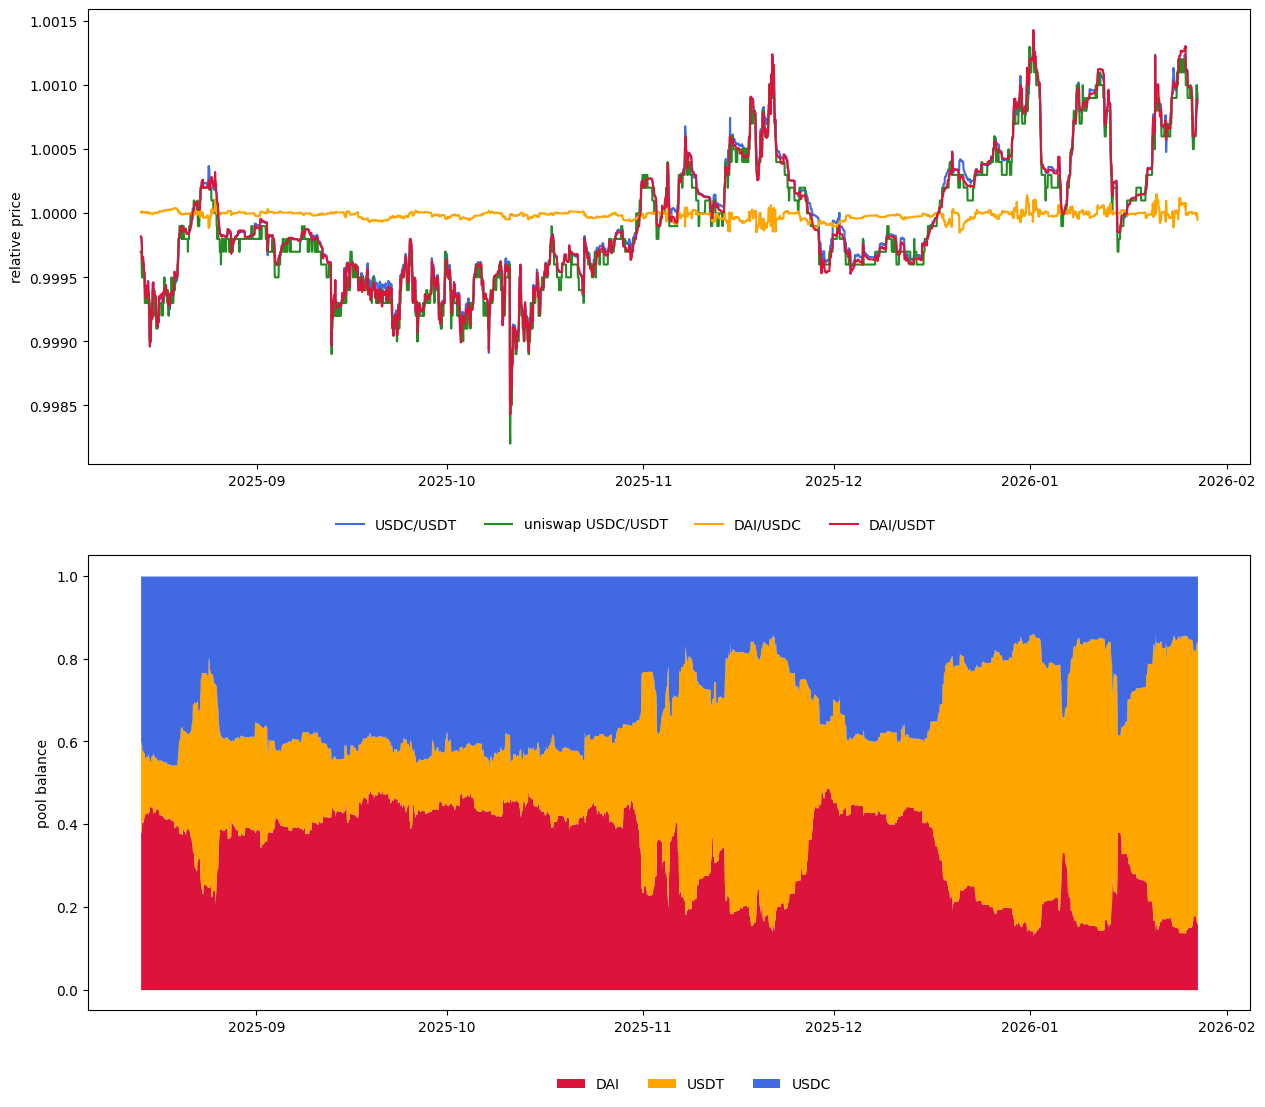

In [55]:
fig, axs = plt.subplots(2,1, figsize = (15,13))
plotdf = threep.iloc[-4000:]
quotes = curve_3pool_spot_quotes(plotdf, A=4000.0, fee_frac=0.0, dx_token=1.0)

axs[1].fill_between(plotdf.index,0,plotdf['w_DAI'], lw = 0, label = 'DAI', color = 'crimson')
axs[1].fill_between(plotdf.index,plotdf['w_DAI'],plotdf['w_DAI']+plotdf['w_USDT'], lw = 0, label = 'USDT', color = 'orange')
axs[1].fill_between(plotdf.index,plotdf['w_DAI']+plotdf['w_USDT'],plotdf['w_DAI']+plotdf['w_USDT']+plotdf['w_USDC'], lw = 0, label = 'USDC', color = 'royalblue')
axs[0].plot(quotes['USDC/USDT'], color ='royalblue', label = 'USDC/USDT')
axs[0].plot(df_uni.hour, 1.0001 ** df_uni.poolTick, color = 'forestgreen', label = 'uniswap USDC/USDT')
axs[0].plot(quotes['DAI/USDC'], color = 'orange', label = 'DAI/USDC')
axs[0].plot(1/quotes['USDT/DAI'], color = 'crimson', label = 'DAI/USDT')
axs[1].set_ylabel('pool balance')
axs[0].set_ylabel('relative price')
axs[0].legend(bbox_to_anchor = (0.74,-0.09), frameon = False, ncols = 4)
axs[1].legend(bbox_to_anchor = (0.65,-0.12), frameon = False, ncols = 3)
plt.savefig('recent_past_3pool_uniswap', transparent = True, dpi = 200, bbox_inches = 'tight')

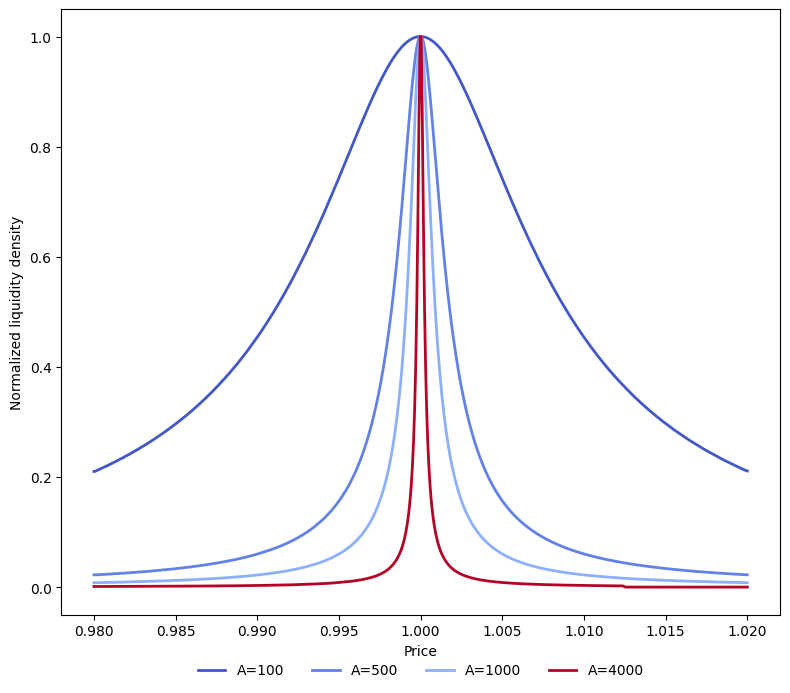

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def get_D(xp, A, n_iter=256):
    n = len(xp)
    S = sum(xp)
    if S == 0:
        return 0.0
    D = S
    Ann = A * n
    for _ in range(n_iter):
        D_prev = D
        D_P = D
        for x in xp:
            D_P = D_P * D / (x * n)
        D = (Ann * S + D_P * n) * D / ((Ann - 1) * D + (n + 1) * D_P)
        if abs(D - D_prev) <= 1e-12 * D:
            break
    return D

def get_y(x, D, A, n_iter=256):
    n = 2
    Ann = A * n
    c = D
    S_ = x
    c = c * D / (x * n)
    c = c * D / (Ann * n)
    b = S_ + D / Ann

    y = D
    for _ in range(n_iter):
        y_prev = y
        y = (y * y + c) / (2 * y + b - D)
        if abs(y - y_prev) <= 1e-12 * y:
            break
    return y

def curve_spot_price(x, D, A, eps=1e-6):
    y1 = get_y(x, D, A)
    y2 = get_y(x * (1.0 + eps), D, A)
    dy_dx = (y2 - y1) / (x * eps)
    return -dy_dx

def curve_effective_liquidity_vs_price(A, x0=1.0, y0=1.0,
                                       P_min=0.98, P_max=1.02,
                                       x_min=0.2, x_max=5.0,
                                       n_x=2000, n_P=400):
    
    D = get_D([x0, y0], A)


    xs = np.logspace(np.log10(x_min), np.log10(x_max), n_x)
    Ps = np.array([curve_spot_price(x, D, A) for x in xs])

    idx = np.argsort(Ps)
    Ps_sorted = Ps[idx]
    xs_sorted = xs[idx]

    P_grid = np.linspace(P_min, P_max, n_P)
    x_of_P = np.interp(P_grid, Ps_sorted, xs_sorted)

    lnP = np.log(P_grid)
    L_eff = np.abs(np.gradient(x_of_P, lnP))
    return P_grid, L_eff

# -----------------------------
# Uniswap v3: user-chosen (concentrated) liquidity distribution
# -----------------------------
def v3_liquidity_distribution(P_grid, positions):
    """
    positions: list of (P_a, P_b, L) where liquidity L is active within [P_a, P_b].
    This matches the typical Uniswap 'liquidity vs price' chart (step function).
    """
    L = np.zeros_like(P_grid, dtype=float)
    for Pa, Pb, Liq in positions:
        L += Liq * ((P_grid >= Pa) & (P_grid <= Pb))
    return L

# -----------------------------
# Plot comparison
# -----------------------------
def plot_curve_vs_uniswap():
    P_min, P_max = 0.98, 1.02
    P_grid = np.linspace(P_min, P_max, 600)

    fig, ax = plt.subplots(figsize=(8, 7))

    # Curve: implied smooth "distribution" controlled by A
    for A in [100, 500, 1000, 4000]:
        P, L_eff = curve_effective_liquidity_vs_price(
            A=A, x0=1.0, y0=1.0, P_min=P_min, P_max=P_max,
            x_min=0.1, x_max=5.0, n_x=3000, n_P=len(P_grid)
        )
        L_eff = L_eff / L_eff.max()  # normalize to compare shapes
        ax.plot(P, L_eff, linewidth=2, label=f"A={A}", color = mpl.colormaps['coolwarm'](A/4000))


    ax.set_xlabel("Price")
    ax.set_ylabel("Normalized liquidity density")
    ax.legend(ncols = 4, frameon = False, bbox_to_anchor= (0.5,-0.06), loc = 'upper center')
    plt.tight_layout()
    plt.savefig('curve_liquidity_distribution', dpi = 200, transparent = True, bbox_inches = 'tight')

if __name__ == "__main__":
    plot_curve_vs_uniswap()

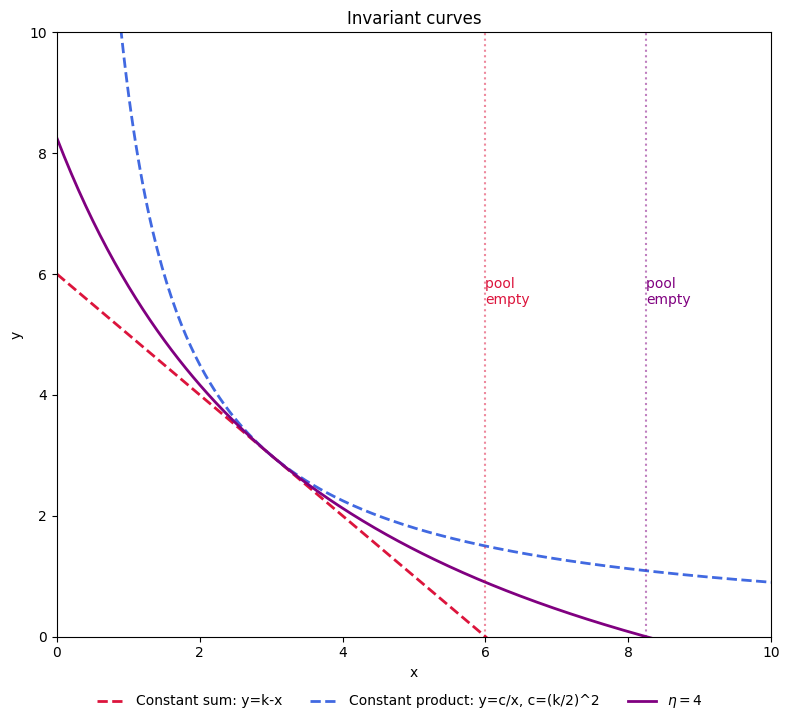

In [52]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(8, 7))
x = np.linspace(0.001, 10, 300)

k = 6
A = 4
c = (k/2)**2  # adjust CP so equilibrium is at (k/2, k/2)

# --- curves (y vs x) ---
y_sum  = k - x
y_prod = c / x
y_crv  = (A*k + c - A*x) / (A + x)


axs.set_xlim((0, 10))
axs.set_ylim((0, 10))

# left subplot: state curves
axs.plot(x, y_sum,  color="crimson",   linestyle="--", label="Constant sum: y=k-x", lw = 2)
axs.plot(x, y_prod, color="royalblue", linestyle="--", label=r"Constant product: y=c/x, c=(k/2)^2", lw = 2)
axs.plot(x, y_crv,  color="purple",                 label=r"$\eta = 4$", lw = 2)
axs.set_title("Invariant curves")
axs.set_ylabel("y")
axs.set_xlabel("x")
# axs[0].legend()

# --- prices (tangent): p = -dy/dx ---
p_sum  = np.ones_like(x)
p_prod = c / x**2
p_crv  = (A**2 + A*k + c) / (A + x)**2  # from analytic derivative of y_crv

# Add annotations where pool can empty (y=0)
x_sum_empty = k  # where y_sum = 0
x_crv_empty = (A*k + c) / A  # where y_crv = 0

axs.axvline(x=x_sum_empty, color="crimson", linestyle=":", alpha=0.5, linewidth=1.5)
axs.axvline(x=x_crv_empty, color="purple", linestyle=":", alpha=0.5, linewidth=1.5)
axs.text(x_sum_empty, 5.5, "pool \nempty", color="crimson", fontsize=10, ha="left")
axs.text(x_crv_empty, 5.5, "pool \nempty", color="purple", fontsize=10, ha="left")

# right subplot: price curves

# axs[0].legend(frameon = False)
# axs[1].legend(frameon = False)
handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, ncols = 3, frameon = False, bbox_to_anchor = (0.9,0.02))

plt.tight_layout()
plt.savefig('constant_sum_product_curve', transparent = True, dpi = 200, bbox_inches = 'tight')

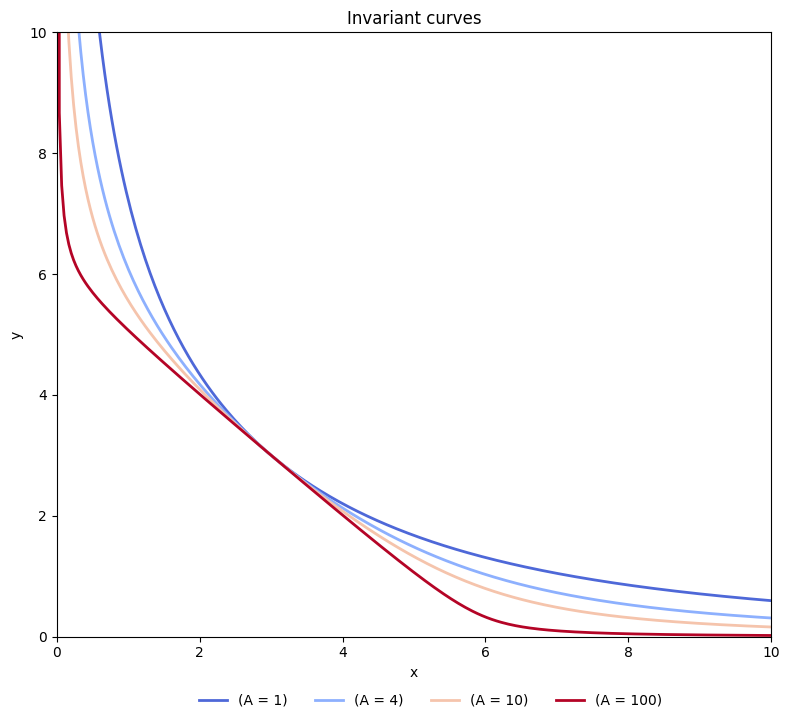

In [53]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(8, 7))
x = np.linspace(0.0001, 10, 300)

k = 6
c = (k/2)**2  # adjust CP so equilibrium is at (k/2, k/2)




axs.set_xlim((0, 10))
axs.set_ylim((0, 10))

for A in [1, 4, 10, 100]:
    # y = np.sqrt((x - k + k**2/4*A)**2 + k**4 / (4*A*x) ) - (x - k + k**2 / 4*A)
    y = (1/2) * (np.sqrt((x + k **2 /(4*A) - k)**2 + k ** 4/ (4*A*x)) - (x + k ** 2 /(4*A) - k))
    axs.plot(x, y,  color=mpl.colormaps['coolwarm'](A/16),label=f"(A = {A})", lw = 2)
axs.set_title("Invariant curves")
axs.set_ylabel("y")
axs.set_xlabel("x")
# axs[0].legend()


handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, ncols = 4, frameon = False, bbox_to_anchor = (0.85,0.02))

plt.tight_layout()
plt.savefig('stableswap_invariant_curves', transparent = True, dpi = 200, bbox_inches = 'tight')